In [94]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [96]:
#import the data and the labels

url3='https://raw.githubusercontent.com/mrvoral/Modeling-Late-Payments-for-Credit-Card-Bills/main/hw07_target3_training_data.csv'
df3 = pd.read_csv(url3)


In [97]:
#import labels
label_url3='https://raw.githubusercontent.com/mrvoral/Modeling-Late-Payments-for-Credit-Card-Bills/main/hw07_target3_training_label.csv'
Labels3 = pd.read_csv(label_url3)


In [98]:
test_url3='https://raw.githubusercontent.com/mrvoral/Modeling-Late-Payments-for-Credit-Card-Bills/main/hw07_target3_test_data.csv'
X_test3=pd.read_csv(test_url3)


#  Deal with NaNs

In [99]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isna().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [100]:
missing_values=missing_values_table(df3)

Your selected dataframe has 203 columns.
There are 68 columns that have missing values.


In [101]:
throw_variables=missing_values[missing_values['% of Total Values']>55]
keep_variables=missing_values[missing_values['% of Total Values']<=55]

In [102]:
#drop mostly na features

df3= df3.drop(columns=[row for row in throw_variables.index])

# df3= df3.drop(columns=["VAR36","VAR153"])

#drop mostly na features
X_test3= X_test3.drop(columns=[row for row in throw_variables.index])
X_test3= X_test3.drop(columns=["VAR36","VAR153"])


# #fill not-a-numbers with the median
X_test3.fillna(X_test3.median(), inplace=True)



# #fill not-a-numbers with the median
df3.fillna(df3.median(), inplace=True)




Y3=np.array(Labels3)[:,1]



In [103]:

numerical_cols =[ind for ind in keep_variables.index if ind not in ["VAR36","VAR153"]]
categorical_cols =  ["VAR36","VAR153"]
df3= df3.drop(columns=categorical_cols)
X_train=df3


# Inputing numerical values with median
numerical_transformer = SimpleImputer(strategy='median')
# # Inputing missing values with most frequent one for categorical data
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols)
       # ,        ('cat', categorical_transformer, categorical_cols)
    ])


preprocess_pipeline=Pipeline(steps=[
    ('preprocessor', preprocessor)
])
X_train_temp=preprocess_pipeline.fit_transform(X_train)



In [104]:
# train a random forest
rfc=RandomForestClassifier()#n_estimators=80,max_depth=7)


## Hyperparameter Search for Target 3



In [105]:
# Number of trees in Random Forest
rf_n_estimators = [int(x) for x in np.linspace(10, 80, 10)]

# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(3, 7, 3)]
# # Add the default as a possible value
rf_max_depth.append(None)

# Number of features to consider at every split
rf_max_features = ['auto', 'sqrt', 'log2']

# Criterion to split on
rf_criterion = ['entropy']#,'gini' ]

# Minimum number of samples required to split a node
rf_min_samples_split = [int(x) for x in np.linspace(2, 10, 3)]

# Minimum decrease in impurity required for split to happen
rf_min_impurity_decrease = [0.0, 0.05, 0.5]

# Method of selecting samples for training each tree
rf_bootstrap = [True]#, False]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
               'max_features': rf_max_features,
               'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
               'min_impurity_decrease': rf_min_impurity_decrease,
               'bootstrap': rf_bootstrap}

clf3 = RandomizedSearchCV(rfc, rf_grid, n_iter=100, random_state=0)



In [106]:
search3 = clf3.fit(df3, Y3)
search3.best_params_


{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'min_impurity_decrease': 0.0,
 'min_samples_split': 10,
 'n_estimators': 80}

In [107]:
best_params=search3.best_params_
# best_params={'bootstrap': True,
#  'criterion': 'entropy',
#  'max_depth': 5,
#  'max_features': 'auto',
#  'min_impurity_decrease': 0.0,
#  'min_samples_split': 0.1,
#  'n_estimators': 80}

In [108]:
# Bundle preprocessing and modeling code 
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(**best_params))
])


In [109]:
#fit and evaluate posterior for training set
#Y_rf = rfc.fit(X, Y)
# Y_pred=rfc.predict_proba(X)[:,1]
pipeline.fit(X_train, Y3)
Y_pred3=pipeline.predict_proba(X_train)[:,1]
# Y_rf2 = rfc2.fit(X2, Y2)
# Y_pred2=rfc2.predict_proba(X2)[:,1]
# Y_rf3 = rfc3.fit(X3, Y3)
# Y_pred3=rfc3.predict_proba(X3)[:,1]


#rfc.best_params_
#calculate mean auroc using 10-fold cross validation
from sklearn.model_selection import cross_validate
scores = cross_validate(pipeline, X_train, Y3, cv=5, scoring=('roc_auc'), return_train_score=True)
print("Mean AUROC for target 1 is:")
print(np.mean(scores['test_score']))

# evaluate posteriors on the test set
# Y_test3=Y_rf3.predict_proba(X_test3)
# #concatanate with ID
# Y_o3=np.concatenate((np.array(X_test3["ID"]).reshape((-1,1)),Y_test3[:,1].reshape((-1,1))),1)

# write predictions to csv files
# pd.DataFrame(Y_o3).to_csv("hw07_target3_test_predictions.csv",header=["ID","TARGET"],index=None)



Mean AUROC for target 1 is:
0.7687914557124491


In [110]:
scores['test_score']

array([0.75810926, 0.77011721, 0.78299854, 0.74998968, 0.78274259])

In [111]:
scores['train_score']

array([0.93703495, 0.93878837, 0.94463595, 0.9435447 , 0.93986605])

In [112]:
# plot ROC curve
from sklearn import metrics
fpr3, tpr3, threshold = metrics.roc_curve(Y3, Y_pred3)


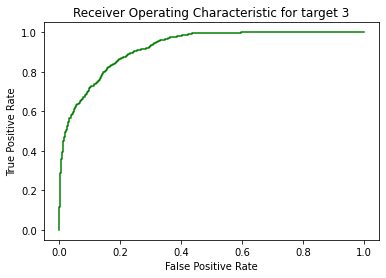

In [113]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic for target 3')
plt.plot(fpr3, tpr3, 'g')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()